In [1]:
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar
!rm images.tar annotations_instance.tar
%pip install -qU torch_snippets
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
%pip install -q -U 'git+https://github.com/sizhky/cocoapi.git@patch-1#subdirectory=PythonAPI'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 86.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
from torch_snippets import *

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

In [4]:
classes_list = [4,6]
annots = []
for ann in Tqdm(all_annots):
  _ann = read(ann, 1).transpose(2,0,1)
  r,g,b = _ann
  if np.array([num in np.unique(r) for num in classes_list]).sum()==0: continue
  annots.append(ann)
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

100%|██████████| 20210/20210 [05:34<00:00, 60.34it/s]


In [5]:
def get_transforms(train):
  transforms = []
  transforms.append(T.PILToTensor())
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [6]:
def get_mask(path):
  an = read(path, 1).transpose(2,0,1)
  r,g,b = an
  cls = list(set(np.unique(r)).intersection({4,6}))
  print(cls)
  masks = []
  labels = []
  for _cls in cls:
    nzs = np.nonzero(r==_cls)
    instances = np.unique(g[nzs])
    for ix,_id in enumerate(instances):
      masks.append(g==_id)
      labels.append(classes_list.index(_cls)+1)
  return np.array(masks), np.array(labels)

In [7]:
_id = trn_items[10]
img_path = f'images/training/{_id}.jpg'

In [9]:
get_mask(img_path)

[4, 6]


(array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, 

In [16]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
    def get_mask(self,path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        cls = list(set(np.unique(r)).intersection({4,6}))
        masks = []
        labels = []
        for _cls in cls:
          nzs = np.nonzero(r==_cls)
          instances = np.unique(g[nzs])
          for ix,_id in enumerate(instances):
              masks.append(g==_id)
              labels.append(classes_list.index(_cls)+1)
        return np.array(masks), np.array(labels)
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks, labels = self.get_mask(mask_path)
        #print(labels)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = ix
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if (img.dtype == torch.float32) or (img.dtype == torch.uint8):
          img = img/255.
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[randint(len(self))]

Image tensor shape: torch.Size([3, 240, 320])
Image tensor dtype: torch.float32
Target dictionary contents:
  boxes: Tensor shape=torch.Size([1, 4]), dtype=torch.float32
  labels: Tensor shape=torch.Size([1]), dtype=torch.int64
  masks: Tensor shape=torch.Size([1, 240, 320]), dtype=torch.uint8
  image_id: type=<class 'int'>, value=1
  area: Tensor shape=torch.Size([1]), dtype=torch.float32
  iscrowd: Tensor shape=torch.Size([1]), dtype=torch.int64


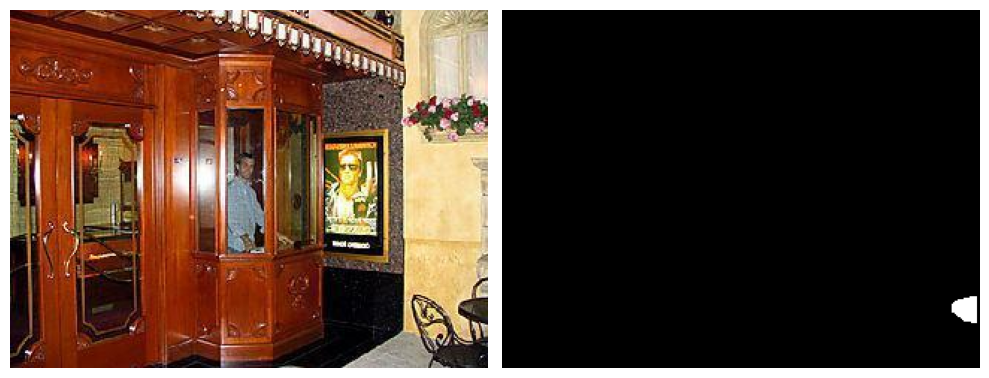

In [18]:
def inspect(image, target):
    print(f"Image tensor shape: {image.shape}")
    print(f"Image tensor dtype: {image.dtype}")
    print("Target dictionary contents:")
    for k, v in target.items():
        if isinstance(v, torch.Tensor):
            print(f"  {k}: Tensor shape={v.shape}, dtype={v.dtype}")
        else:
            print(f"  {k}: type={type(v)}, value={v}")

x = MasksDataset(trn_items, get_transforms(train=True), N=100)
im,targ = x[1]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)

In [19]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [20]:
model = get_model_instance_segmentation(3).to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:01<00:00, 93.6MB/s]


In [22]:
dataset = MasksDataset(trn_items, get_transforms(train=True), N=3000)
dataset_test = MasksDataset(val_items, get_transforms(train=False), N=800)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [23]:
num_classes = 3
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
model.eval()
pred = model(dataset[0][0][None].to(device))
inspect(dataset[0][0], pred[0])

Image tensor shape: torch.Size([3, 512, 783])
Image tensor dtype: torch.float32
Target dictionary contents:
  boxes: Tensor shape=torch.Size([100, 4]), dtype=torch.float32
  labels: Tensor shape=torch.Size([100]), dtype=torch.int64
  scores: Tensor shape=torch.Size([100]), dtype=torch.float32
  masks: Tensor shape=torch.Size([100, 1, 512, 783]), dtype=torch.float32


In [ ]:
num_epochs = 3

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [   0/1500]  eta: 1 day, 4:50:24  lr: 0.000010  loss: 4.4966 (4.4966)  loss_classifier: 0.9652 (0.9652)  loss_box_reg: 0.4623 (0.4623)  loss_mask: 3.0081 (3.0081)  loss_objectness: 0.0497 (0.0497)  loss_rpn_box_reg: 0.0113 (0.0113)  time: 69.2162  data: 0.1068


/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [  10/1500]  eta: 23:32:59  lr: 0.000060  loss: 3.5445 (3.5772)  loss_classifier: 0.8313 (0.8365)  loss_box_reg: 0.3390 (0.3514)  loss_mask: 2.1966 (2.3348)  loss_objectness: 0.0394 (0.0417)  loss_rpn_box_reg: 0.0115 (0.0128)  time: 56.8993  data: 0.0549
Epoch: [0]  [  20/1500]  eta: 22:44:44  lr: 0.000110  loss: 2.7247 (2.9586)  loss_classifier: 0.6182 (0.6810)  loss_box_reg: 0.2156 (0.2601)  loss_mask: 1.7766 (1.9256)  loss_objectness: 0.0376 (0.0689)  loss_rpn_box_reg: 0.0116 (0.0229)  time: 54.6327  data: 0.0509
Epoch: [0]  [  30/1500]  eta: 22:57:14  lr: 0.000160  loss: 1.6826 (2.4934)  loss_classifier: 0.3810 (0.5606)  loss_box_reg: 0.1320 (0.2598)  loss_mask: 1.1435 (1.5939)  loss_objectness: 0.0341 (0.0571)  loss_rpn_box_reg: 0.0083 (0.0219)  time: 55.8366  data: 0.0552
Epoch: [0]  [  40/1500]  eta: 23:14:37  lr: 0.000210  loss: 1.5040 (2.2438)  loss_classifier: 0.2597 (0.4992)  loss_box_reg: 0.1877 (0.2770)  loss_mask: 0.7554 (1.3832)  loss_objectness: 0.0341 (0.06

In [ ]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

In [ ]:
model.eval()
k+=1
im = dataset_test[k][0]
show(im,sz=5)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()